# get signal

In [3]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests
from funcs import *
import pickle
import warnings

warnings.simplefilter("error")

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
tickerpairs=["ETCUSDT","GBPUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","AUDUSDT","XMRUSDT"] 

intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']



# define constants
tickerpair="ETCUSDT"
interval="5m"
percentile=98
thres_diff=None
entered=False

percentiles = [99]
intervals=['5m','15m','30m']#[-1:]
tickerpairs=['ARBUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BTCUSDT',
             'ETCUSDT', 'ETHUSDT', 'LTCUSDT', 'MATICUSDT','SHIBUSDT', 
             'SOLUSDT','WAVESUSDT','XRPUSDT']
tickerpairs=os.listdir("kline_data/")
#tickerpairs=["ARBUSDT","ETCUSDT","LTCUSDT","ETHUSDT","BTCUSDT","BNBUSDT","XVGUSDT"]#[:1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:

with open('trading_pairs.pkl', 'rb') as f:
    trading_pairs = pickle.load(f)

In [8]:
[t["symbol"] for t in trading_pairs[:150]]

['BTCUSDT',
 'EDUUSDT',
 'ETHUSDT',
 'USDCUSDT',
 'BUSDUSDT',
 'XRPUSDT',
 'SOLUSDT',
 'BNBUSDT',
 'ARBUSDT',
 'ALPHAUSDT',
 'IDUSDT',
 'CFXUSDT',
 'TUSDUSDT',
 'RNDRUSDT',
 'APTUSDT',
 'INJUSDT',
 'DOGEUSDT',
 'MATICUSDT',
 'LTCUSDT',
 'RADUSDT',
 'ICPUSDT',
 'EURUSDT',
 'FILUSDT',
 'LINAUSDT',
 'LINKUSDT',
 'FTMUSDT',
 'DYDXUSDT',
 'ADAUSDT',
 'WOOUSDT',
 'TRXUSDT',
 'ATOMUSDT',
 'HOOKUSDT',
 'OGUSDT',
 'RDNTUSDT',
 'DOTUSDT',
 'GALAUSDT',
 'COCOSUSDT',
 'LUNAUSDT',
 'LUNCUSDT',
 'JASMYUSDT',
 'AVAXUSDT',
 'OPUSDT',
 'TOMOUSDT',
 'CAKEUSDT',
 'USTCUSDT',
 'EGLDUSDT',
 'IDEXUSDT',
 'FETUSDT',
 'SHIBUSDT',
 'GMTUSDT',
 'STMXUSDT',
 'AGIXUSDT',
 'ORNUSDT',
 'XMRUSDT',
 'BETAUSDT',
 'LQTYUSDT',
 'SANDUSDT',
 'STGUSDT',
 'VGXUSDT',
 'SXPUSDT',
 'BELUSDT',
 'MDTUSDT',
 'CTSIUSDT',
 'STXUSDT',
 'ROSEUSDT',
 'AUDUSDT',
 'ACHUSDT',
 'MAGICUSDT',
 'VTHOUSDT',
 'MASKUSDT',
 'EOSUSDT',
 'HIGHUSDT',
 'IMXUSDT',
 'NEARUSDT',
 'UMAUSDT',
 'GRTUSDT',
 'AKROUSDT',
 'ETCUSDT',
 'APEUSDT',
 'BCHUSDT',


In [2]:
%%time
dfmpl = get_data(tickerpair,"30m",limit=55000,type="data")
len(dfmpl)

CPU times: total: 312 ms
Wall time: 411 ms


55000

In [3]:
print("total",len(tickerpairs)*len(intervals)*len(percentiles))

total 750


In [ ]:
%%time
count=0;fee=0.0015
times=[]
print("total",len(tickerpairs)*len(intervals)*len(percentiles))
for tickerpair in tickerpairs[::-1]:#[:5]:
    for interval in intervals:
        times.append( time.time() )
        try:
            dfmpl = get_data(tickerpair,interval,limit=55000,type="data")
        except ValueError:
            continue
        #if len(dfmpl)<20000:continue
        times.append( time.time() )
        for percentile in percentiles:
            if count%10==0:print(count,end=" ")#,tickerpair,interval,percentile)
            count+=1
            thres_diff=None
            entered=False
            times.append( time.time() )
            entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff = get_entrys_exits(dfmpl,percentile,thres_diff)
            times.append( time.time() )
            predict,result,predict_seq,predicted_result = get_predictions(entrys,exits,dfmpl)
            times.append( time.time() )
            lastNsamples = int(len(result)*0.1)
            profit,trade_dur, df0, df0_signal,hl_pair = get_profit_highlows_of_predictions(entrys,exits,predicted_result,dfmpl,True)
            times.append( time.time() )
            profit = [p-fee for p in profit]
            if len(profit)==0:
                print("\nzero profit",tickerpair,interval,percentile)
                continue
            final_profit,equity = get_all_equity(profit,fee=0)
            
            pickled_data=(entrys,exits,sc_up,sc_dn,r_high_sm,r_low_sm,r_sm,r_sm_diff,thres_diff,
                          predict,result,predict_seq,predicted_result,
                          profit,trade_dur, df0, df0_signal,hl_pair,
                          final_profit,equity
                         )
            with open(f"5_9_2_data/plotdata_{tickerpair}_{interval}_{percentile}.pkl","wb") as f:
                pickle.dump(pickled_data,f)
            times.append( time.time() )

total 750
0 10 20 30 40 50 60 70 80 90 100 110 120 130 

# todo: extract the relevant columns

In [18]:
#(np.asarray(times).reshape(15,-1)-np.asarray(times).reshape(15,-1)[:,0][:,np.newaxis]).T
np.diff(np.asarray(times).reshape(15,-1),axis=1).shape

(15, 6)

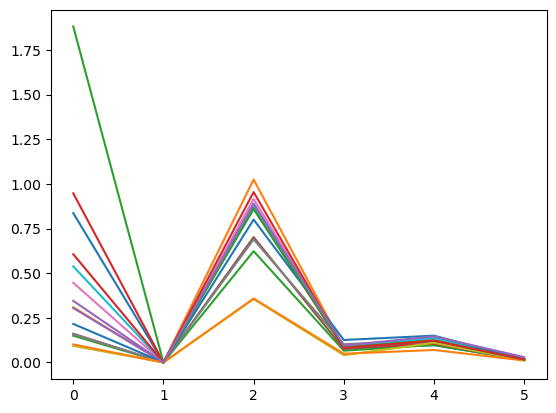

In [30]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

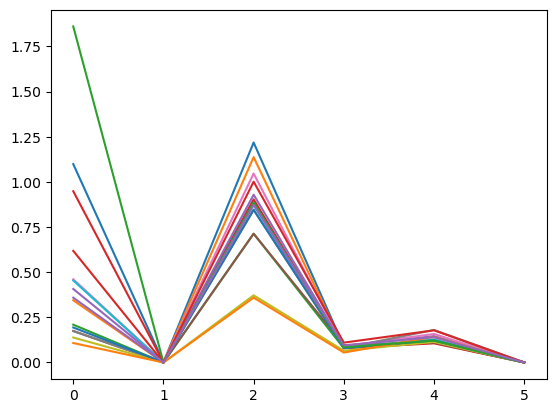

In [22]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

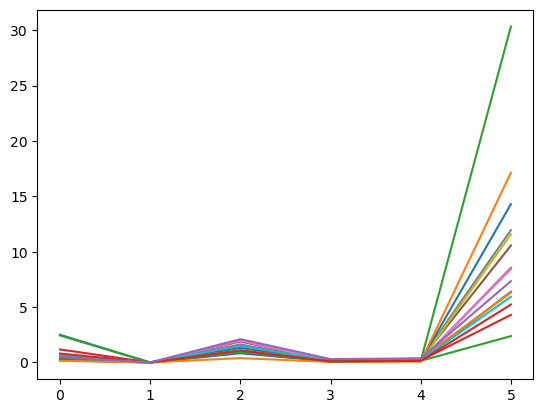

In [20]:
plt.plot(np.diff(np.asarray(times).reshape(15,-1),axis=1).T);

## sort by avg profit

In [5]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9_others.data","r") as f:
    data =f.readlines()

In [6]:
arr = [d[:-1].split(",") for d in data]

In [7]:
#[arr[i] for i in np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])][:15]

In [9]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9.data","r") as f:
    data =f.readlines()

In [11]:
#strr = "".join([data[i] for i in np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])])
strr=""
for counter,i in enumerate(np.argsort([-1*(float(a[-2])-float(a[-1])) for a in arr])):
    strr+='{"id'+f'":{counter},'+data[i][:-1]+"},\n"

In [12]:
with open(f"5_9_0figures_percentile_ticker_buynfee/collected_data5_9_others_sorted.data","w") as f:
    f.writelines(strr)

In [14]:
import random

1.4604162622819006

In [13]:
time.sleep(random.uniform(0.5,2))

In [ ]:
if False:
    continue
            fig,(ax1,ax2)=plt.subplots(2,1,figsize=(8,5),sharex=True,dpi=100)
            ax1.plot(equity,"-x")
            ax1.set_ylabel("equity (start with $1)")
            ax1.set_title(f"{tickerpair} {interval} {percentile}% fee{fee} buy only")
            str1,gains_,trading_days,gains_per_day,gains_per_trade,avg_prof,wr= get_stats(dfmpl,sc_up,profit,trade_dur,0,fee=0)
            gs = get_stats(dfmpl,sc_up,profit,trade_dur,lastNsamples,fee=0)[0]
            ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
            ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+gs,transform=ax1.transAxes,va="top",ha="left")
            ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
            ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
            ax2.plot(profit,"x")
            ax2.axhline(0,c="r",alpha=0.3)
            ax2.set_ylabel("profit per trade")
            ax2.text(0.02,0.99,f"full len={len(dfmpl)}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
            #ax2.text(0.02,0.99,f"thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
            for ax in (ax1,ax2):
                ax.set_xlabel("trades")
                ax.tick_params("both",direction="in")
            ax2.yaxis.set_minor_locator(AutoMinorLocator())
            ax2.tick_params("y",which='minor',color="r")
            ax2.grid(which='minor',axis="y",alpha=0.5)
            ax2.grid(which='major',axis="y",color="r",alpha=0.5)
            #lt.tight_layout(h_pad=-1.08)

            ax3 = ax2.inset_axes((1.05,0.1,0.3,0.3)) 
            ax3.text(0,1,"pfHist,g/trd",transform=ax3.transAxes,va="top",ha="left")
            ax3.hist(profit,bins=100)
            ax3.axvline(0,c="r",alpha=0.3)
            ax3.tick_params("both",direction="in",rotation=25,color="r") 
            ax3.set_yticks([])
            ax3.set_facecolor(f'#00{intpl(gains_per_trade*10,0,20):02X}0f60')
            ax4 = ax2.inset_axes((1.05,0.65,0.3,0.3))
            ax4.hist(r_sm_diff,bins=100)
            ax4.text(0,1,"thresDiff,g/day",transform=ax4.transAxes,va="top",ha="left") 
            ax4.axvline(thres_diff,c="r")
            ax4.tick_params("both",direction="in",rotation=25,color="r")
            ax4.set_yticks([])
            ax4.set_facecolor(f'#00{intpl(gains_per_day*10,0,20):02X}0f60')

            ax5 = ax1.inset_axes((1.05,0.0,0.4,0.99))
            hl_data = get_hl_data(hl_pair,buyonly=True) 
            plot_hl_ax(ax5,hl_pair,hl_data,bres=0.1,buyonly=True) 
            plt.tight_layout(h_pad=-1.08)
            #plt.savefig(f"5_8figures_percentile_ticker/{tickerpair}_{interval}_pcent{int(percentile):05d}.png") 
            plt.savefig(f"5_9_1_figures_temp/FeeBO_{tickerpair}_{interval}_pcent{int(percentile):05d}.png")
            plt.close("all")

In [5]:
%%time
if False:
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
    ax1.plot(r_high_sm,alpha=0.6)
    ax1.plot(r_low_sm,alpha=0.6)
    ax1.plot(r_sm,alpha=0.6)
    ax1.set_xticks(ax1.get_xticks())
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    n,bins,_ = ax2.hist(r_sm,bins=100)
    thres = np.percentile(r_sm.values[np.where(~np.isnan(r_sm.values))],25)
    ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
    ax2.legend()
    ax3.hist(r_sm_diff,bins=100)
    ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
    ax3.legend()
    plt.show()  
if False:
    upto=20
    concated_df = pd.concat([(i-i.iloc[0].Open)/i.iloc[0].Open for i in df0[:upto]])
    l_ = 0
    scatter_=[]
    scatter_color_up=[]
    scatter_color_dn=[]
    my_vlines = [ ]
    for i,buy in zip( df0[:upto], df0_signal):
        my_vlines.append(l_)
        for ii in range(len(i)):
            l_ +=1
            scatter_.append(np.nan)
            scatter_color_up.append(np.nan)
            scatter_color_dn.append(np.nan)
        scatter_.pop()
        scatter_.append(concated_df.iloc[l_-1].Close)
        if buy>0:
            scatter_color_up.pop()
            scatter_color_up.append(concated_df.iloc[l_-1].Close)
        else:
            scatter_color_dn.pop()
            scatter_color_dn.append(concated_df.iloc[l_-1].Close)
    apds = [
        mpf.make_addplot(scatter_color_up,color='g',type='scatter',marker="x",secondary_y=False),
        mpf.make_addplot(scatter_color_dn,color='r',type='scatter',marker="x",secondary_y=False),
           ]
    fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True,ylabel="fraction change")
    for ax in axlist[:]:
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
    plt.show()
    import matplotlib
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

CPU times: total: 0 ns
Wall time: 0 ns
